<a href="https://colab.research.google.com/github/tomorn112/ZC-DINO-ER/blob/part3/SAADuck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Set-up environment

Let's first install 🤗 Transformers. We install from source as the model is brand new at the moment of writing.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!nvidia-smi

Mon Mar 10 14:01:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!git clone https://github.com/caoyunkang/Segment-Any-Anomaly.git
%cd Segment-Any-Anomaly/
!ls

fatal: destination path 'Segment-Any-Anomaly' already exists and is not an empty directory.
/content/Segment-Any-Anomaly
app.py	  demo.py	 install.sh  run_KSDD2.py  run_VAND_workshop.py  SAM
assets	  eval_SAA.py	 LICENSE     run_MTD.py    run_VisA_public.py	 utils
datasets  GroundingDINO  README.md   run_MVTec.py  SAA			 weights


In [ ]:
%cd GroundingDINO/
!pip install -e .
%cd ../SAM
!pip install -e .
!pip install opencv-python pycocotools matplotlib onnxruntime onnx ipykernel gradio loguru

/content/Segment-Any-Anomaly/GroundingDINO
Obtaining file:///content/Segment-Any-Anomaly/GroundingDINO
  Preparing metadata (setup.py) ... done
  Attempting uninstall: groundingdino
    Found existing installation: groundingdino 0.1.0
    Uninstalling groundingdino-0.1.0:
      Successfully uninstalled groundingdino-0.1.0
  Running setup.py develop for groundingdino
/content/Segment-Any-Anomaly/SAM
Obtaining file:///content/Segment-Any-Anomaly/SAM
  Preparing metadata (setup.py) ... done
  Attempting uninstall: SAM
    Found existing installation: SAM 1.0
    Uninstalling SAM-1.0:
      Successfully uninstalled SAM-1.0
  Running setup.py develop for SAM


In [ ]:
%cd ..
%mkdir weights
%cd ./weights
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
!wget https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
%cd ..

/content/Segment-Any-Anomaly
mkdir: cannot create directory ‘weights’: File exists
/content/Segment-Any-Anomaly/weights
--2025-03-10 14:02:17--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 18.173.166.74, 18.173.166.48, 18.173.166.51, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|18.173.166.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2564550879 (2.4G) [binary/octet-stream]
Saving to: ‘sam_vit_h_4b8939.pth.1’

sam_vit_h_4b8939.pt 100%[===================>]   2.39G   178MB/s    in 13s     

2025-03-10 14:02:31 (182 MB/s) - ‘sam_vit_h_4b8939.pth.1’ saved [2564550879/2564550879]

--2025-03-10 14:02:31--  https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting 

In [ ]:
import sys
sys.path.append('./GroundingDINO')
sys.path.append('./SAM')
sys.path.append('.')
import matplotlib.pyplot as plt
import SAA as SegmentAnyAnomaly
from utils.training_utils import *
import os
%matplotlib inline

/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [ ]:
gpu_id = 0

os.environ['CURL_CA_BUNDLE'] = ''
os.environ['CUDA_VISIBLE_DEVICES'] = f"{gpu_id}"


dino_config_file = 'GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py'
dino_checkpoint = 'weights/groundingdino_swint_ogc.pth'
sam_checkpoint = 'weights/sam_vit_h_4b8939.pth'
box_threshold = 0.1
text_threshold = 0.1
eval_resolution = 1024
device = f"cuda:0"
root_dir = 'result'

# get the model
model = SegmentAnyAnomaly.Model(
    dino_config_file=dino_config_file,
    dino_checkpoint=dino_checkpoint,
    sam_checkpoint=sam_checkpoint,
    box_threshold=box_threshold,
    text_threshold=text_threshold,
    out_size=eval_resolution,
    device=device,
)

model = model.to(device)


/usr/local/lib/python3.11/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


final text_encoder_type: bert-base-uncased


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/content/Segment-Any-Anomaly/SAA/model.py:94: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This 

build_sam_vit_h


/content/Segment-Any-Anomaly/SAM/segment_anything/build_sam.py:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


wide_resnet50_2


# Model parameter count

In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters: {trainable_params:,}")


Total Parameters: 197,702,210
Trainable Parameters: 197,111,618


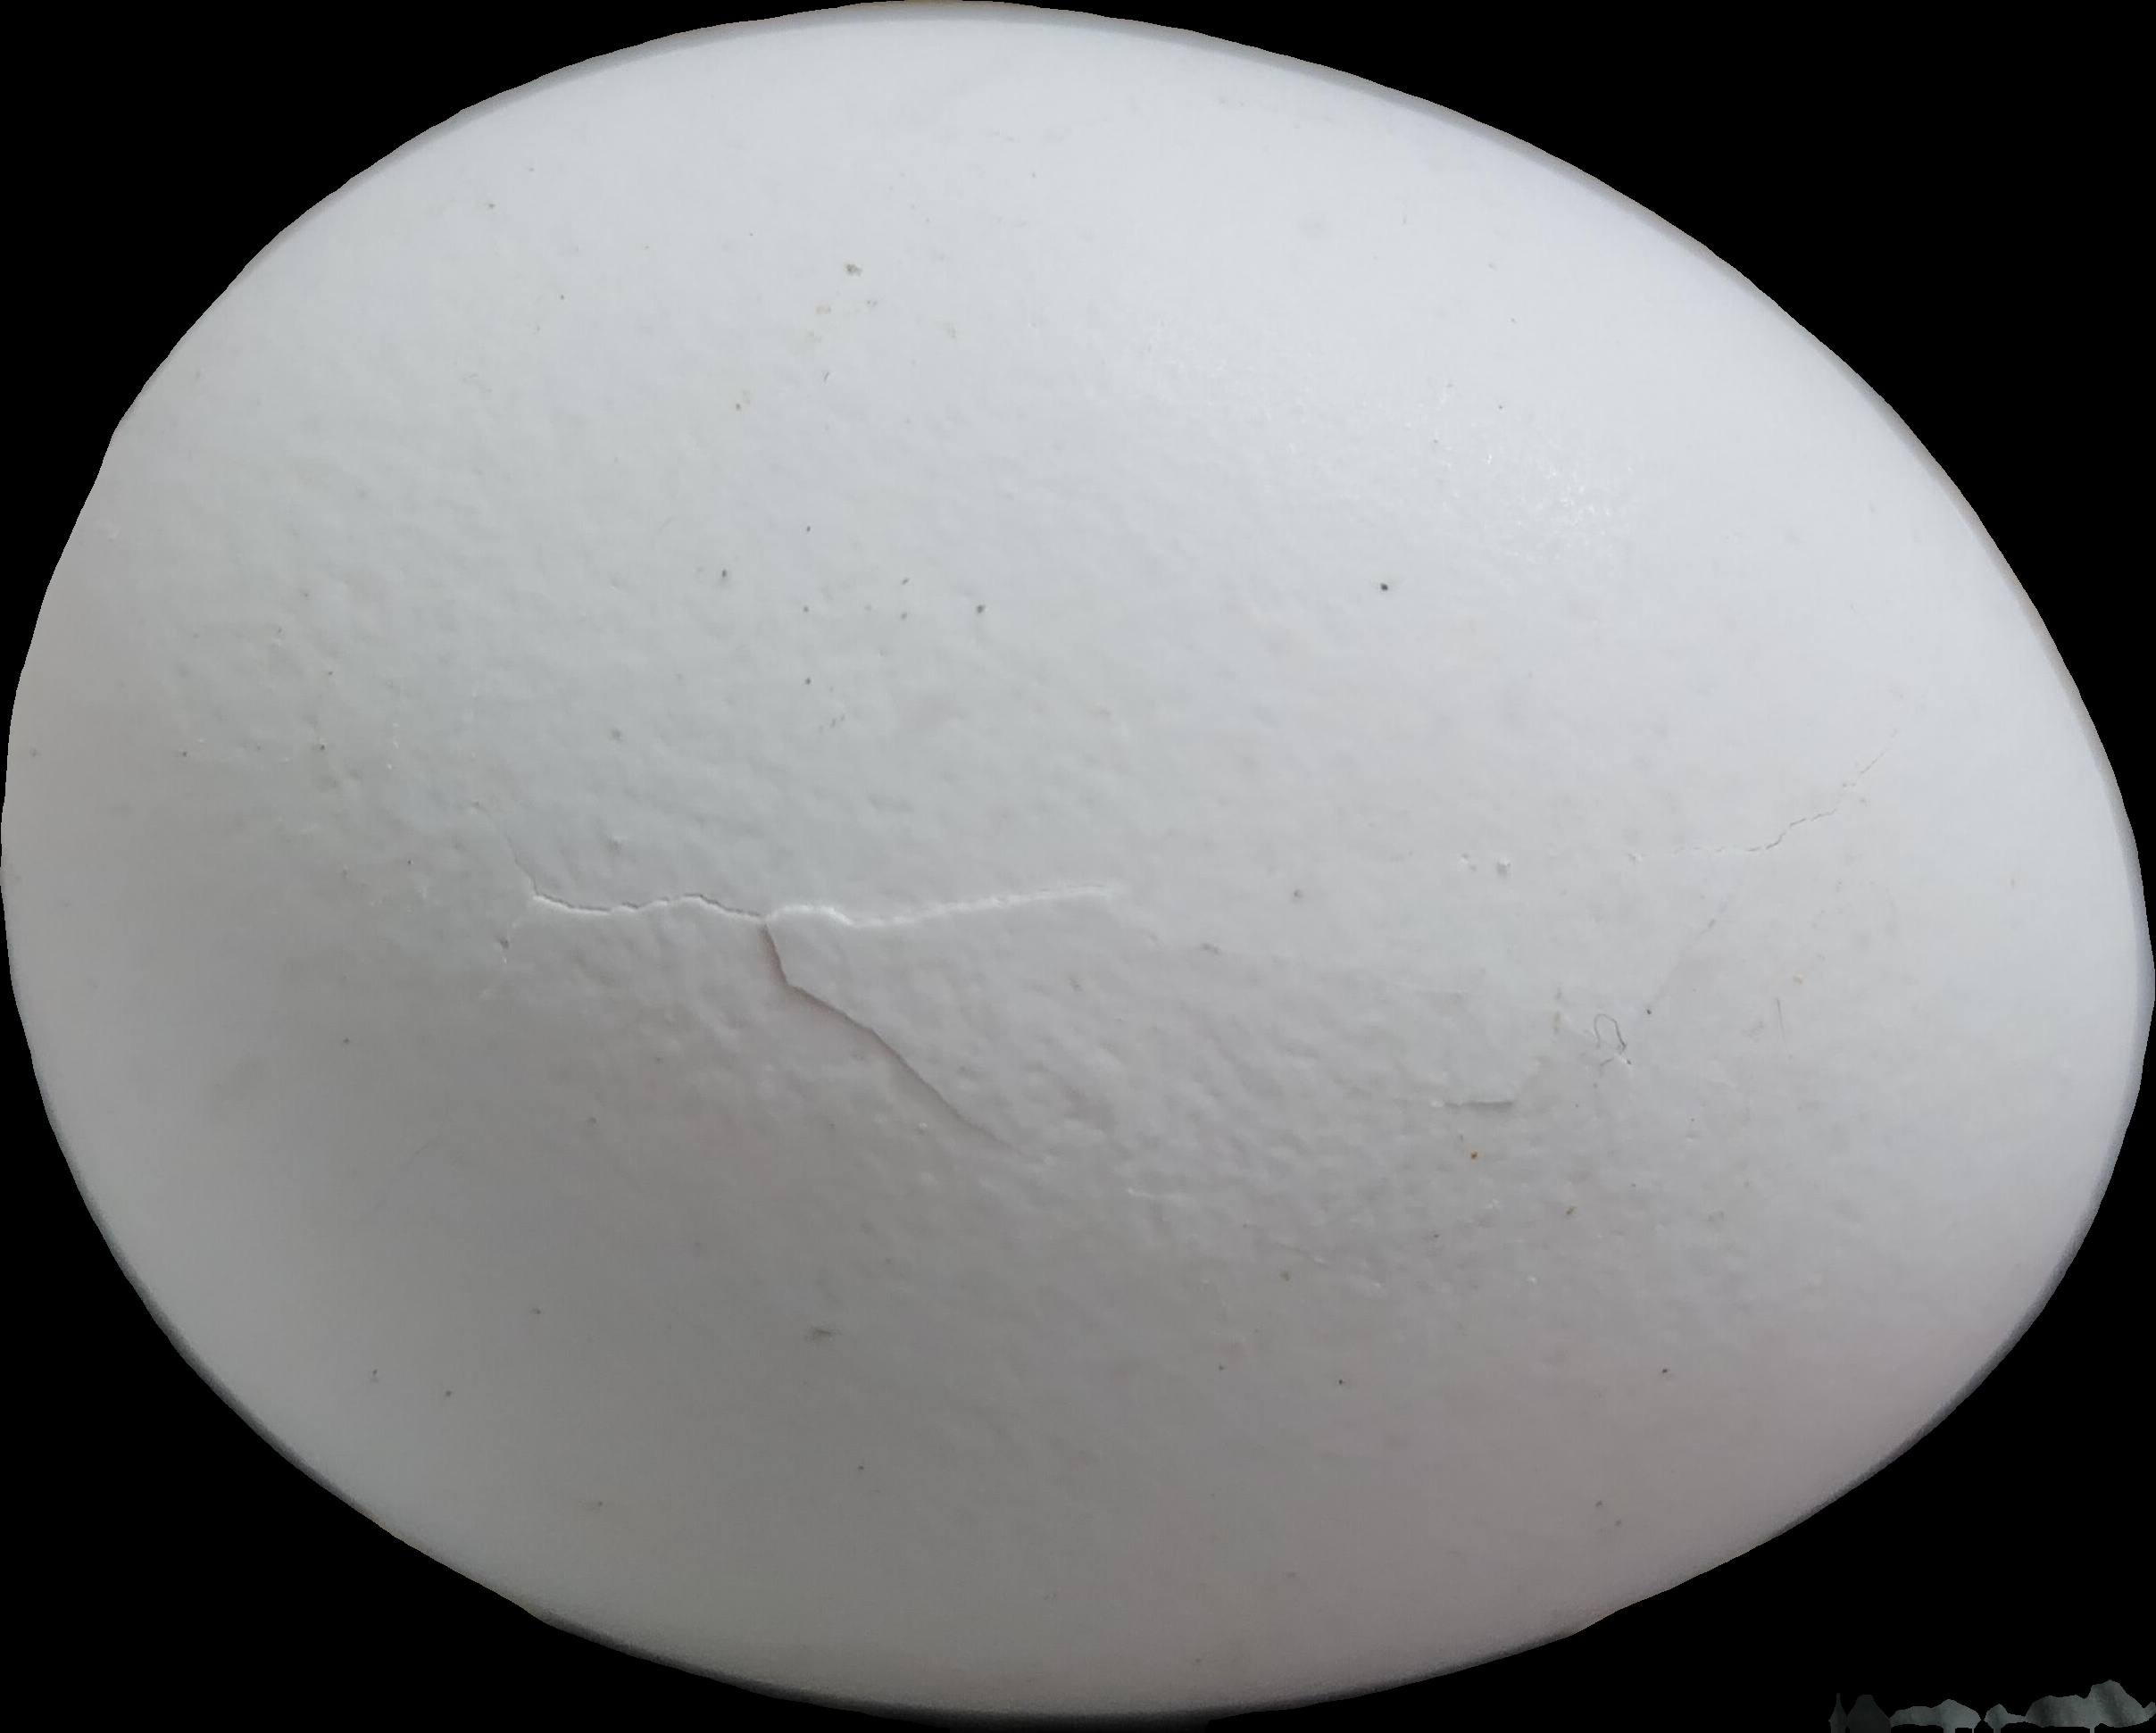

In [ ]:
import cv2
from google.colab.patches import cv2_imshow

# image_path = 'assets/candle.JPG'
# textual_prompts = ['color defect. hole. black defect. wick hole. spot. ', 'candle'] # detect prompts, filtered phrase
# property_text_prompts = 'the image of candle have 4 similar candle, with a maximum of 1 anomaly. The anomaly would not exceed 0.3 object area. '

# image_path = 'assets/carpet.png'
# textual_prompts = ['defect. ', 'carpet'] # detect prompts, filtered phrase
# property_text_prompts = 'the image of carpet have 1 dissimilar carpet, with a maximum of 5 anomaly. The anomaly would not exceed 0.9 object area. '

image_path = '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/crack_cropped/cropped_IMG_20220812_104309_egg.jpg'
textual_prompts = [
    ['crack', 'egg'],
]

property_text_prompts = 'the image of egg have 1 dissimilar egg, with a maximum of 1 anomaly. The anomaly would not exceed 1 object area. '


image = cv2.imread(image_path)
cv2_imshow(image)

used ensemble text prompts ===========
det prompts: crack
filtered background: egg
egg,, 1, 1, 1.0, 1.0, 0.0


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


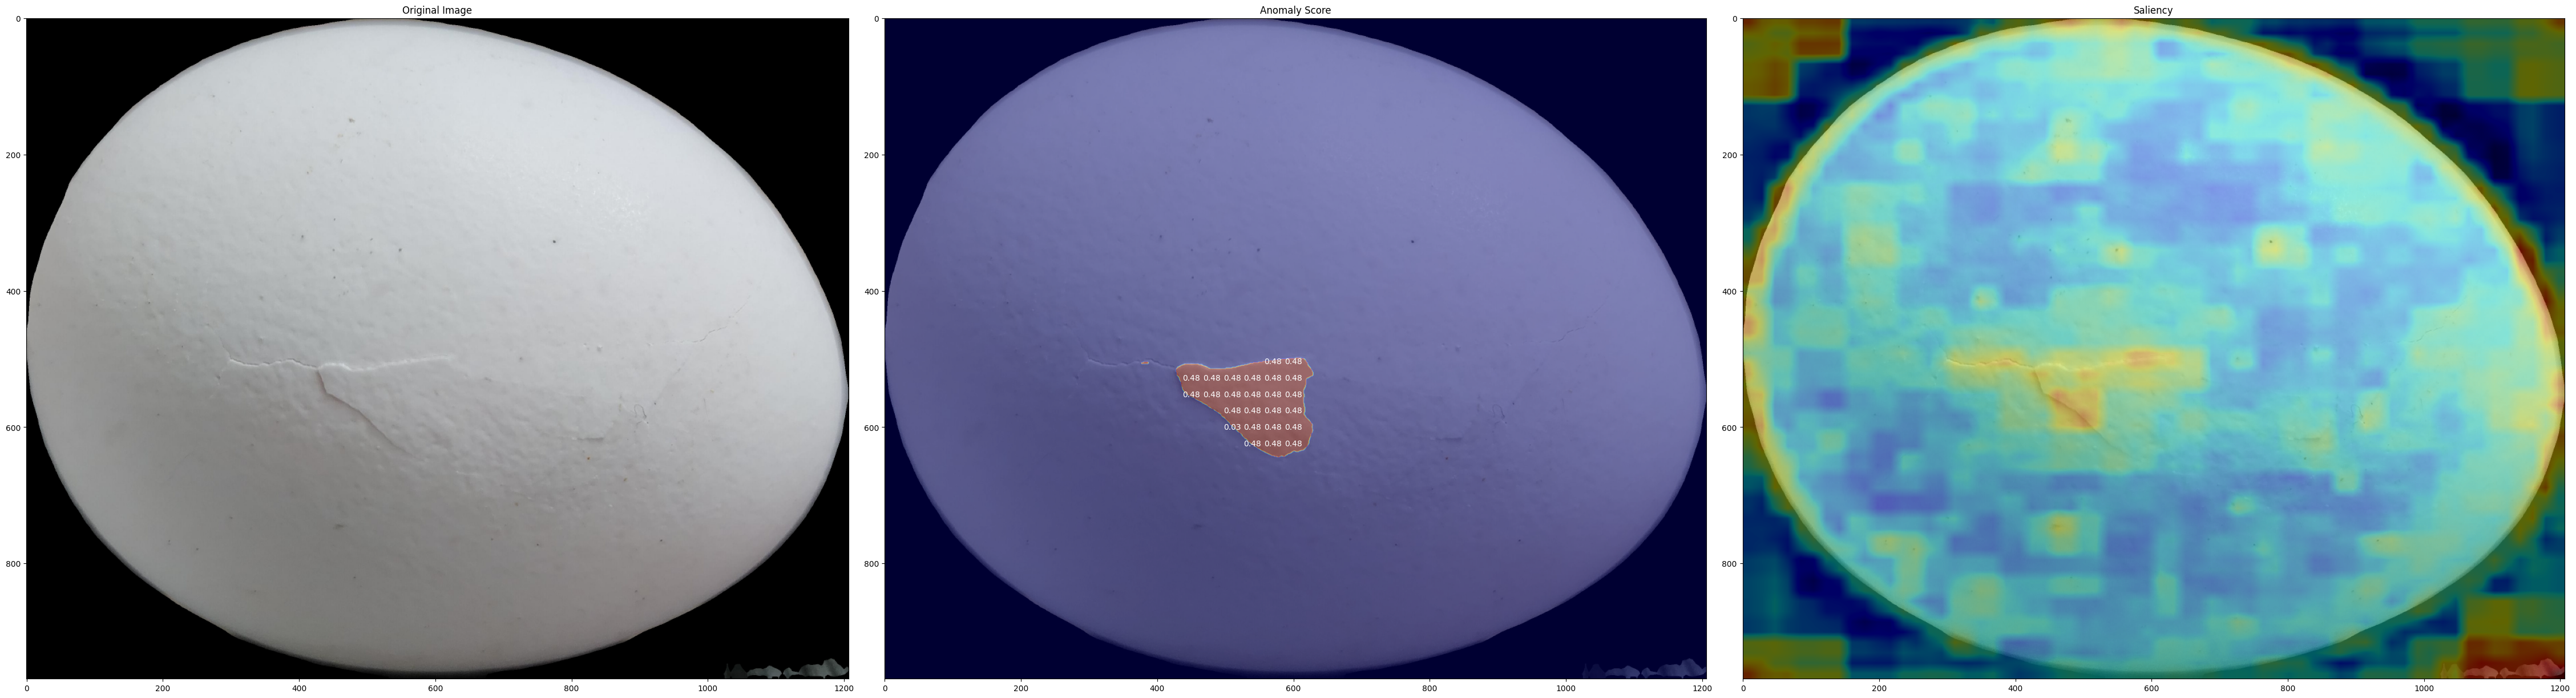

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Load your image
image_path =  '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/crack_cropped/cropped_IMG_20220812_104309_egg.jpg'  # Replace with the actual image path
image = cv2.imread(image_path)

# Resize the image to 50% before processing
scale_percent = 50  # Scale down to 50%
new_width = int(image.shape[1] * scale_percent / 100)
new_height = int(image.shape[0] * scale_percent / 100)
resized_image = cv2.resize(image, (new_width, new_height))

# Update evaluation resolution
eval_resolution = (resized_image.shape[1], resized_image.shape[0])

# Assuming model and text prompts are already initialized
model.set_ensemble_text_prompts(textual_prompts, verbose=True)
model.set_property_text_prompts(property_text_prompts, verbose=True)

# Run model inference
score, appendix = model(resized_image)
similarity_map = appendix['similarity_map']

# Convert BGR to RGB for correct display
image_show = cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB)

# Resize outputs to match evaluation resolution
image_show = cv2.resize(image_show, eval_resolution)
similarity_map = cv2.resize(similarity_map, eval_resolution)
score = cv2.resize(score, eval_resolution)

# Set figure size dynamically based on resized image size
dpi = 80
fig_width = eval_resolution[0] / dpi
fig_height = eval_resolution[1] / dpi

# Create figure
plt.figure(figsize=(fig_width * 3, fig_height * 1))  # Width increased for 3 subplots

# Plot the original image
plt.subplot(131)
plt.imshow(image_show)
plt.title('Original Image')

# Plot the anomaly score
plt.subplot(132)
plt.imshow(image_show)
plt.imshow(score, alpha=0.4, cmap='jet')
plt.title('Anomaly Score')

# Annotate the figure with anomaly scores
row_step = max(5, eval_resolution[1] // 40)  # Adaptive step size
col_step = max(5, eval_resolution[0] // 40)
for i in range(0, score.shape[0], row_step):
    for j in range(0, score.shape[1], col_step):
        score_value = score[i, j]
        if score_value > 0:  # Only annotate positive scores
            plt.text(j, i, f"{score_value:.2f}", fontsize=10, color='white', ha='center', va='center')

# Plot the saliency map
plt.subplot(133)
plt.imshow(image_show)
plt.imshow(similarity_map, alpha=0.4, cmap='jet')
plt.title('Saliency')

plt.tight_layout()  # Ensure proper spacing
plt.show()


In [ ]:
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-rrkixpba
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-rrkixpba
  Resolved https://github.com/ultralytics/ultralytics.git to commit bf3501554b9779dd7bdce2301e76b72a1c1b8b2b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Find Latency, Inferent time, FPS, cpu gpu usage, memory usage

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import psutil
import torch
from natsort import natsorted
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.modeling_utils")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.checkpoint")

def get_system_usage():
    """Retrieve CPU, GPU, and memory usage before and after inference."""
    cpu_usage = psutil.cpu_percent(interval=None)  # CPU usage in percentage
    mem_usage = psutil.virtual_memory().percent   # Memory usage in percentage
    gpu_usage = None
    gpu_mem = None

    if torch.cuda.is_available():
        gpu_usage = torch.cuda.utilization(0)  # GPU usage in percentage
        gpu_mem = torch.cuda.memory_allocated(0) / (1024 ** 2)  # GPU memory in MB

    return cpu_usage, mem_usage, gpu_usage, gpu_mem

def process_image(file_path, model, textual_prompts, property_text_prompts, mask_directory, output_directory=None):
    global list_cracked

    # Read the image
    image = cv2.imread(file_path)
    fixed_size = (512, 512)  # Fixed size for equal display

    # Resize image for processing
    image_resized = cv2.resize(image, fixed_size)

    # Construct the path for the corresponding mask
    mask_path = os.path.join(mask_directory, os.path.basename(file_path))

    # Read the binary mask and resize it
    mask = cv2.imread(mask_path, 0) if os.path.exists(mask_path) else None
    if mask is not None:
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = cv2.resize(mask, fixed_size)

    try:
        # Start measuring inference time
        start_time = time.time()
        cpu_before, mem_before, gpu_before, gpu_mem_before = get_system_usage()

        model.set_ensemble_text_prompts(textual_prompts, verbose=False)
        model.set_property_text_prompts(property_text_prompts, verbose=False)

        score, appendix = model(image_resized)
        similarity_map = appendix['similarity_map']

        # End measuring inference time
        end_time = time.time()
        inference_time = end_time - start_time  # Latency in seconds
        fps = 1 / inference_time if inference_time > 0 else 0  # FPS calculation

        # Get system usage after inference
        cpu_after, mem_after, gpu_after, gpu_mem_after = get_system_usage()

        # Calculate resource consumption
        cpu_usage = cpu_after - cpu_before
        mem_usage = mem_after - mem_before
        gpu_usage = (gpu_after - gpu_before) if gpu_after is not None else None
        gpu_mem_usage = (gpu_mem_after - gpu_mem_before) if gpu_mem_after is not None else None

        # Resize for visualization
        image_show = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        score_resized = cv2.resize(score, fixed_size)
        similarity_map_resized = cv2.resize(similarity_map, fixed_size)

        mask_percentage = None
        binary_crack_mask = np.zeros(fixed_size, dtype=np.uint8)
        if mask is not None:
            score_positive = score_resized > 0
            total_score_area = np.sum(score_positive)
            total_white_mask_area = np.sum(mask == 255)

            if total_white_mask_area > 0:
                mask_percentage = (total_score_area / total_white_mask_area) * 100
            else:
                mask_percentage = 0

            score_mask = score_positive & (mask == 255)
            is_cracked = np.any(score_mask)

            binary_crack_mask[score_positive] = 255
        else:
            is_cracked = False

        if is_cracked:
            list_cracked.append(os.path.basename(file_path))

        # Print system performance metrics
        print(f"\nPerformance Metrics for {os.path.basename(file_path)}")
        print(f"Latency (Inference Time): {inference_time:.4f} sec")
        print(f"FPS: {fps:.2f}")
        print(f"CPU Usage Change: {cpu_usage:.2f}%")
        print(f"Memory Usage Change: {mem_usage:.2f}%")
        if gpu_usage is not None:
            print(f"GPU Usage Change: {gpu_usage:.2f}%")
            print(f"GPU Memory Change: {gpu_mem_usage:.2f} MB")

        # Plotting
        plt.figure(figsize=(15, 5))  # Adjusted figure size
        plt.subplot(1, 5, 1)
        plt.imshow(image_show)
        plt.title('Original Image', fontsize=12)

        plt.subplot(1, 5, 2)
        plt.imshow(similarity_map_resized, cmap='jet')
        plt.title('Saliency Map', fontsize=12)

        plt.subplot(1, 5, 3)
        plt.imshow(image_show)
        plt.imshow(score_resized, alpha=0.4, cmap='coolwarm')
        title_text = 'Cracked' if is_cracked else 'Anomaly Score'
        plt.title(title_text, fontsize=12)

        if mask is not None:
            plt.subplot(1, 5, 4)
            plt.imshow(mask, cmap='gray')
            plt.title('Egg mask', fontsize=12)

            plt.subplot(1, 5, 5)
            plt.imshow(binary_crack_mask, cmap='gray')
            mask_title = f'Saliency score: {mask_percentage:.2f}%' if mask_percentage is not None else 'Mask'
            plt.title(mask_title, fontsize=12)

        # Save the result image if output directory is provided
        if output_directory:
            output_path = os.path.join(output_directory, f'result_{os.path.basename(file_path)}')
            plt.savefig(output_path)
            plt.close()

        plt.show()

    except RuntimeError as e:
        print(f"Runtime error during processing {file_path}: {e}")
    except AttributeError as e:
        print(f"Attribute error during processing {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error during processing {file_path}: {e}")

# Define paths and variables
directory_path_intact = '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/intact_cropped_aug'
directory_path_crack = '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/crack_cropped'
mask_path_intact = '/content/drive/My Drive/maskDuck/intact'
mask_path_crack = '/content/drive/My Drive/maskDuck/crack'
output_directory = '/content/SAAresults'
list_cracked = []

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)
max_images = 2

# Process images
def process_images(directory_path, mask_path, model, textual_prompts, property_text_prompts, output_directory, max_images):
    image_counter = 0
    for filename in natsorted(os.listdir(directory_path)):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            file_path = os.path.join(directory_path, filename)
            process_image(file_path, model, textual_prompts, property_text_prompts, mask_directory=mask_path, output_directory=output_directory)
            image_counter += 1
            if image_counter >= max_images:
                break

# Process intact images
process_images(directory_path_intact, mask_path_intact, model, textual_prompts, property_text_prompts, output_directory, max_images)

# Process crack images
process_images(directory_path_crack, mask_path_crack, model, textual_prompts, property_text_prompts, output_directory, max_images)


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_103314_egg_aug_0.jpg
Latency (Inference Time): 2.5202 sec
FPS: 0.40
CPU Usage Change: 14.00%
Memory Usage Change: 0.10%
GPU Usage Change: 92.00%
GPU Memory Change: 0.00 MB


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_103314_egg_aug_1.jpg
Latency (Inference Time): 2.4451 sec
FPS: 0.41
CPU Usage Change: -19.70%
Memory Usage Change: 0.00%
GPU Usage Change: 83.00%
GPU Memory Change: 0.00 MB


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_104309_egg.jpg
Latency (Inference Time): 2.5132 sec
FPS: 0.40
CPU Usage Change: -6.60%
Memory Usage Change: 0.00%
GPU Usage Change: 94.00%
GPU Memory Change: 0.00 MB


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_104320_egg.jpg
Latency (Inference Time): 2.4913 sec
FPS: 0.40
CPU Usage Change: -5.50%
Memory Usage Change: 0.00%
GPU Usage Change: 91.00%
GPU Memory Change: 0.00 MB


/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_103314_egg_aug_0.jpg
Latency (Inference Time): 2.5055 sec
FPS: 0.40
CPU Usage Change: 11.10%
Memory Usage Change: 0.00%
GPU Usage Change: 87.00%
GPU Memory Change: 0.00 MB


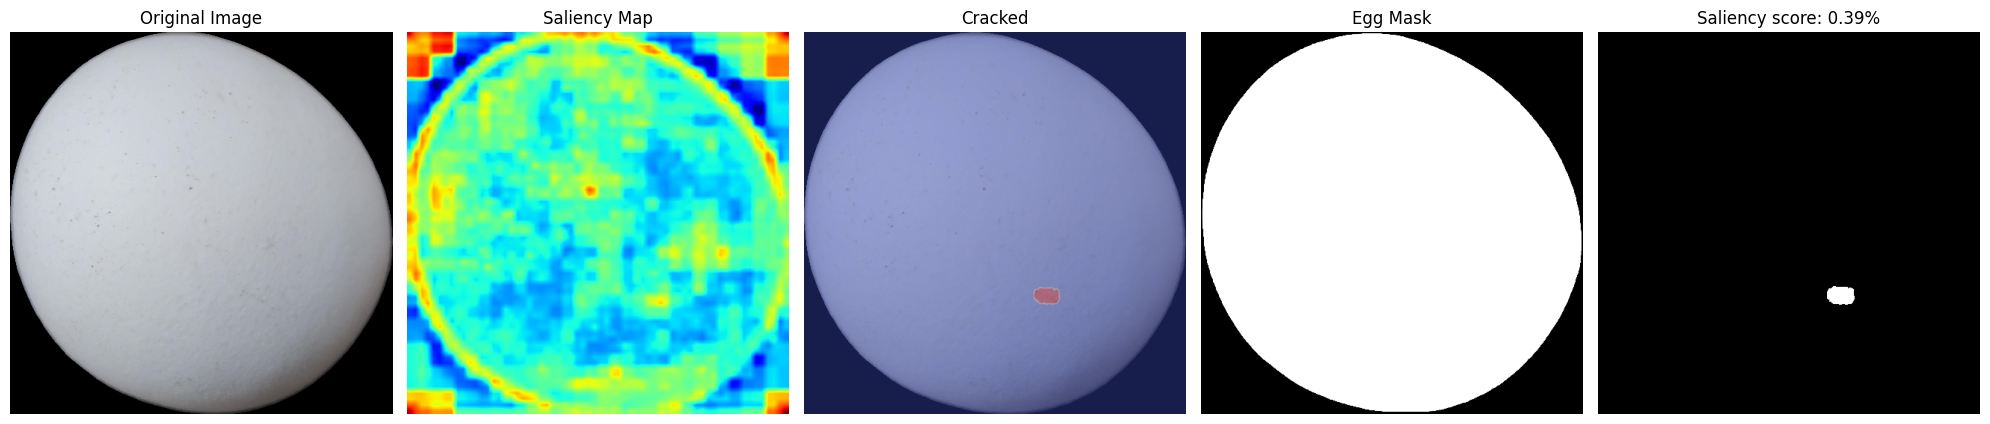

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_103314_egg_aug_1.jpg
Latency (Inference Time): 2.5253 sec
FPS: 0.40
CPU Usage Change: -10.00%
Memory Usage Change: -0.10%
GPU Usage Change: 86.00%
GPU Memory Change: 0.00 MB


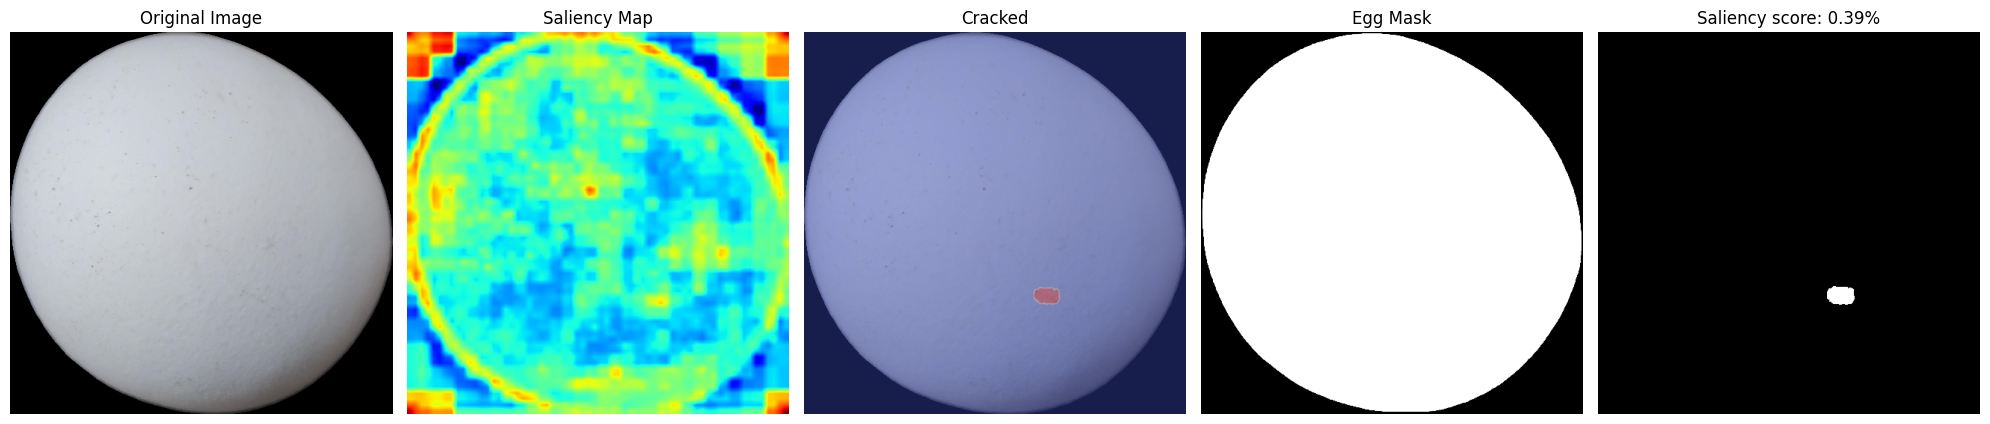

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_104309_egg.jpg
Latency (Inference Time): 2.5768 sec
FPS: 0.39
CPU Usage Change: -3.50%
Memory Usage Change: 0.00%
GPU Usage Change: 83.00%
GPU Memory Change: 0.00 MB


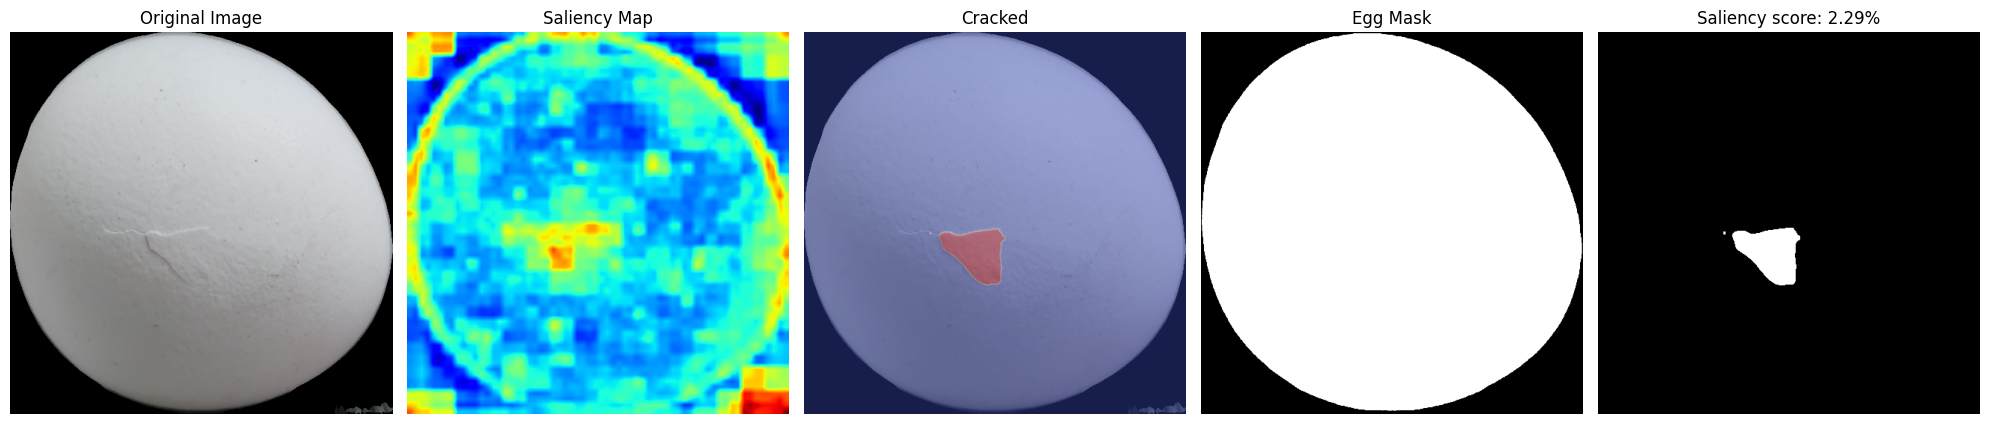

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):



Performance Metrics for cropped_IMG_20220812_104320_egg.jpg
Latency (Inference Time): 2.6034 sec
FPS: 0.38
CPU Usage Change: -7.70%
Memory Usage Change: 0.00%
GPU Usage Change: 80.00%
GPU Memory Change: 0.00 MB


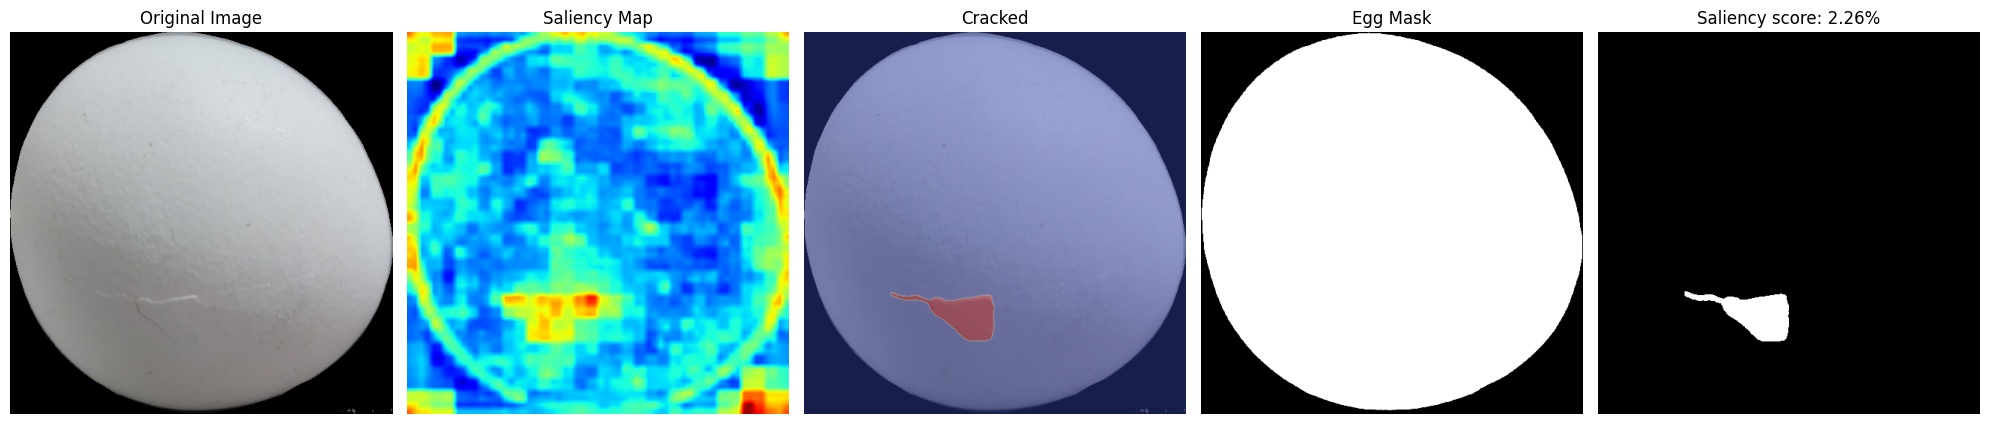

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import psutil
import torch
from natsort import natsorted
import warnings

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.modeling_utils")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.checkpoint")

def get_system_usage():
    """Retrieve CPU, GPU, and memory usage before and after inference."""
    cpu_usage = psutil.cpu_percent(interval=None)  # CPU usage in percentage
    mem_usage = psutil.virtual_memory().percent   # Memory usage in percentage
    gpu_usage = None
    gpu_mem = None

    if torch.cuda.is_available():
        gpu_usage = torch.cuda.utilization(0)  # GPU usage in percentage
        gpu_mem = torch.cuda.memory_allocated(0) / (1024 ** 2)  # GPU memory in MB

    return cpu_usage, mem_usage, gpu_usage, gpu_mem

def process_image(file_path, model, textual_prompts, property_text_prompts, mask_directory, output_directory=None):
    global list_cracked

    # Read the image
    image = cv2.imread(file_path)
    fixed_size = (512, 512)  # Fixed size for equal display

    # Resize image for processing
    image_resized = cv2.resize(image, fixed_size)

    # Construct the path for the corresponding mask
    mask_path = os.path.join(mask_directory, os.path.basename(file_path))

    # Read the binary mask and resize it
    mask = cv2.imread(mask_path, 0) if os.path.exists(mask_path) else None
    if mask is not None:
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = cv2.resize(mask, fixed_size)

    try:
        # Start measuring inference time
        start_time = time.time()
        cpu_before, mem_before, gpu_before, gpu_mem_before = get_system_usage()

        model.set_ensemble_text_prompts(textual_prompts, verbose=False)
        model.set_property_text_prompts(property_text_prompts, verbose=False)

        score, appendix = model(image_resized)
        similarity_map = appendix['similarity_map']

        # End measuring inference time
        end_time = time.time()
        inference_time = end_time - start_time  # Latency in seconds
        fps = 1 / inference_time if inference_time > 0 else 0  # FPS calculation

        # Get system usage after inference
        cpu_after, mem_after, gpu_after, gpu_mem_after = get_system_usage()

        # Calculate resource consumption
        cpu_usage = cpu_after - cpu_before
        mem_usage = mem_after - mem_before
        gpu_usage = (gpu_after - gpu_before) if gpu_after is not None else None
        gpu_mem_usage = (gpu_mem_after - gpu_mem_before) if gpu_mem_after is not None else None

        # Resize for visualization
        image_show = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        score_resized = cv2.resize(score, fixed_size)
        similarity_map_resized = cv2.resize(similarity_map, fixed_size)

        mask_percentage = None
        binary_crack_mask = np.zeros(fixed_size, dtype=np.uint8)
        if mask is not None:
            score_positive = score_resized > 0
            total_score_area = np.sum(score_positive)
            total_white_mask_area = np.sum(mask == 255)

            if total_white_mask_area > 0:
                mask_percentage = (total_score_area / total_white_mask_area) * 100
            else:
                mask_percentage = 0

            score_mask = score_positive & (mask == 255)
            is_cracked = np.any(score_mask)

            binary_crack_mask[score_positive] = 255
        else:
            is_cracked = False

        if is_cracked:
            list_cracked.append(os.path.basename(file_path))

        # Print system performance metrics
        print(f"\nPerformance Metrics for {os.path.basename(file_path)}")
        print(f"Latency (Inference Time): {inference_time:.4f} sec")
        print(f"FPS: {fps:.2f}")
        print(f"CPU Usage Change: {cpu_usage:.2f}%")
        print(f"Memory Usage Change: {mem_usage:.2f}%")
        if gpu_usage is not None:
            print(f"GPU Usage Change: {gpu_usage:.2f}%")
            print(f"GPU Memory Change: {gpu_mem_usage:.2f} MB")

        # Plotting - Fixed to correctly display all 5 images
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))  # Ensure enough space for 5 images

        axes[0].imshow(image_show)
        axes[0].set_title('Original Image', fontsize=12)
        axes[0].axis('off')

        axes[1].imshow(similarity_map_resized, cmap='jet')
        axes[1].set_title('Saliency Map', fontsize=12)
        axes[1].axis('off')

        axes[2].imshow(image_show)
        axes[2].imshow(score_resized, alpha=0.4, cmap='coolwarm')
        title_text = 'Cracked' if is_cracked else 'Anomaly Score'
        axes[2].set_title(title_text, fontsize=12)
        axes[2].axis('off')

        if mask is not None:
            axes[3].imshow(mask, cmap='gray')
            axes[3].set_title('Egg Mask', fontsize=12)
            axes[3].axis('off')

            axes[4].imshow(binary_crack_mask, cmap='gray')
            mask_title = f'Saliency score: {mask_percentage:.2f}%' if mask_percentage is not None else 'Mask'
            axes[4].set_title(mask_title, fontsize=12)
            axes[4].axis('off')

        # Adjust layout to prevent overlapping
        plt.tight_layout()

        # Save the result image if output directory is provided
        if output_directory:
            output_path = os.path.join(output_directory, f'result_{os.path.basename(file_path)}')
            plt.savefig(output_path, dpi=300)

        # Display all images
        plt.show()

    except RuntimeError as e:
        print(f"Runtime error during processing {file_path}: {e}")
    except AttributeError as e:
        print(f"Attribute error during processing {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error during processing {file_path}: {e}")

# Define paths and variables
directory_path_intact = '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/intact_cropped_aug'
directory_path_crack = '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/crack_cropped'
mask_path_intact = '/content/drive/My Drive/maskDuck/intact'
mask_path_crack = '/content/drive/My Drive/maskDuck/crack'
output_directory = '/content/SAAresults'
list_cracked = []

# Ensure the output directory exists
os.makedirs(output_directory, exist_ok=True)
max_images = 2

# Process images
def process_images(directory_path, mask_path, model, textual_prompts, property_text_prompts, output_directory, max_images):
    image_counter = 0
    for filename in natsorted(os.listdir(directory_path)):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            file_path = os.path.join(directory_path, filename)
            process_image(file_path, model, textual_prompts, property_text_prompts, mask_directory=mask_path, output_directory=output_directory)
            image_counter += 1
            if image_counter >= max_images:
                break

# Process intact images
process_images(directory_path_intact, mask_path_intact, model, textual_prompts, property_text_prompts, output_directory, max_images)

# Process crack images
process_images(directory_path_crack, mask_path_crack, model, textual_prompts, property_text_prompts, output_directory, max_images)


# Calculate performance

/usr/local/lib/python3.11/dist-packages/torch/_dynamo/eval_frame.py:632: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.5 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/content/Segment-Any-Anomaly/GroundingDINO/groundingdino/models/GroundingDINO/transformer.py:877: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Accuracy: 0.71
Precision: 0.90
Recall: 0.48
F1 Score: 0.62


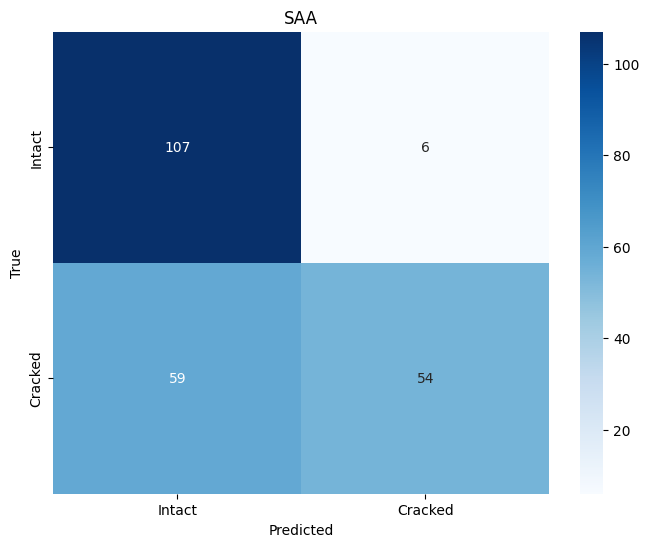

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from natsort import natsorted
import warnings
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers.modeling_utils")
warnings.filterwarnings("ignore", category=UserWarning, module="torch.utils.checkpoint")

y_true = []
y_pred = []

def process_image(file_path, model, textual_prompts, property_text_prompts, mask_directory):
    global list_cracked, y_true, y_pred

    # Determine true label based on directory structure
    true_label = 1 if 'crack' in mask_directory else 0
    y_true.append(true_label)

    # Read the image
    image = cv2.imread(file_path)
    fixed_size = (512, 512)  # Fixed size for equal display

    # Resize image for processing
    image_resized = cv2.resize(image, fixed_size)

    # Construct the path for the corresponding mask
    mask_path = os.path.join(mask_directory, os.path.basename(file_path))

    # Read the binary mask and resize it
    mask = cv2.imread(mask_path, 0) if os.path.exists(mask_path) else None
    if mask is not None:
        # Convert to binary mask (assuming white region is the area of interest)
        _, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
        mask = cv2.resize(mask, fixed_size)

    try:
        model.set_ensemble_text_prompts(textual_prompts, verbose=False)
        model.set_property_text_prompts(property_text_prompts, verbose=False)

        score, appendix = model(image_resized)
        similarity_map = appendix['similarity_map']

        # Resize for visualization
        score_resized = cv2.resize(score, fixed_size)

        mask_percentage = 0
        if mask is not None:
            score_positive = score_resized > 0
            total_score_area = np.sum(score_positive)
            total_white_mask_area = np.sum(mask == 255)

            if total_white_mask_area > 0:
                mask_percentage = (total_score_area / total_white_mask_area) * 100

        is_cracked = mask_percentage > 1
        y_pred.append(1 if is_cracked else 0)

    except RuntimeError as e:
        print(f"Runtime error during processing {file_path}: {e}")
    except AttributeError as e:
        print(f"Attribute error during processing {file_path}: {e}")
    except Exception as e:
        print(f"Unexpected error during processing {file_path}: {e}")

# Define paths and variables
directory_path_intact = '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/intact_cropped_aug'
directory_path_crack = '/content/drive/My Drive/IEEE_Access/Egg/test_ref1/fastsam/crack_cropped'
mask_path_intact = '/content/drive/My Drive/maskDuck/intact'
mask_path_crack = '/content/drive/My Drive/maskDuck/crack'
list_cracked = []
max_images = 113

# Process 2 images for intact and crack
def process_images(directory_path, mask_path, model, textual_prompts, property_text_prompts, max_images):
    image_counter = 0
    for filename in natsorted(os.listdir(directory_path)):
        if filename.endswith(".png") or filename.endswith(".jpg"):  # You can add more file extensions if needed
            file_path = os.path.join(directory_path, filename)
            process_image(file_path, model, textual_prompts, property_text_prompts, mask_directory=mask_path)
            image_counter += 1
            if image_counter >= max_images:
                break

# Process intact images
process_images(directory_path_intact, mask_path_intact, model, textual_prompts, property_text_prompts, max_images=max_images)

# Process crack images
process_images(directory_path_crack, mask_path_crack, model, textual_prompts, property_text_prompts, max_images=max_images)

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Intact', 'Cracked'], yticklabels=['Intact', 'Cracked'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SAA')
plt.show()
